In [4]:
# Sinan Yumurtaci
# Code along for Chapter 4 of fast.ai's Practical Deep Learning for Coders

# Digit classification task
# Distinguish between images of digits
# Data source: MNIST

# 2nd section dedicated for using a NN on MNIST

# 2021-03-30

In [5]:
# imports as we follow along with fastbook

from fastbook import *
setup_book()
from fastai.vision.widgets import *

matplotlib.rc("image", cmap = "Greys")

In [6]:
# load the MNIST dataset
# book loads only 3 and 7 for demonstration.

# I'll be working on the classification for 3s and 5s
# so that I learn new stuff!
path = untar_data(URLs.MNIST)
threes = (path/"training"/"3").ls().sorted()
fives = (path/"training"/"5").ls().sorted()
print(f"There are {len(threes)} 3s and {len(fives)} 5s.")

# load the actual images into tensors
three_tensors = [tensor(Image.open(f)) for f in threes]
five_tensors = [tensor(Image.open(f)) for f in fives]

print(f"Loaded {len(three_tensors)} 3s and {len(five_tensors)} 5s!")

# stack the images for faster computation with PyTorch
# also convert from [0, 255] to [0, 1]
stacked_threes = torch.stack(three_tensors).float()/255
stacked_fives = torch.stack(five_tensors).float()/255

There are 6131 3s and 5421 5s.
Loaded 6131 3s and 5421 5s!


In [7]:
# put our training data in one variable
train_x = torch.cat([stacked_threes, stacked_fives]).view(-1, 28*28)

In [8]:
# create a tensor of labels for our training data
train_y = tensor([1]*len(threes) + [0] * len(fives)).unsqueeze(1)
train_x.shape, train_y.shape

(torch.Size([11552, 784]), torch.Size([11552, 1]))

In [9]:
# zip our data and labels into a dataset (a tuple of (x,y), as PyTorch requires)
dset = list(zip(train_x, train_y))

In [10]:
# repeat the above steps for our test set
test_3_tens = torch.stack([tensor(Image.open(o)) for o in (path/'testing'/'3').ls()]).float()/255
test_5_tens = torch.stack([tensor(Image.open(o)) for o in (path/'testing'/'5').ls()]).float()/255

test_x = torch.cat([test_3_tens, test_5_tens]).view(-1, 28*28)
test_y = tensor([1]*len(test_3_tens) + [0] * len(test_5_tens)).unsqueeze(1)
test_dset = list(zip(test_x, test_y))

len(dset), len(test_dset)

(11552, 1902)

In [11]:
# create function that will return randomly initialized parameters of the specified size
def init_params(size, std = 1.0):
    return (torch.randn(size) * std).requires_grad_()

weights = init_params((28*28,1))
bias    = init_params(1)

In [12]:
# create function that will calculate prediction using the input, and the weights and the bias
def linear_calc(xb):
    return xb @ weights + bias

# calculate predictions for the training set using our initial, random parameters
preds = linear_calc(train_x)
preds

tensor([[ -6.2330],
        [-10.6388],
        [-20.8865],
        ...,
        [  0.7257],
        [-10.1060],
        [-18.4670]], grad_fn=<AddBackward0>)

In [13]:
# calculate our accuracy on the training set
corrects = (preds > 0.5).float() == train_y # if prediction is stronger than 0.5, count as predicting for 3. else, 5
corrects.float().mean().item()

0.4904778301715851

## A Loss Function
Simply accuracy won't work as a loss function, because it is not continious. If we were to change one of the parameters slightly, the accuracy would not change, as demonstrated below:

In [14]:
weights[0] *= 1.00001
preds = linear_calc(train_x)
((preds>0.5).float() == train_y).float().mean().item()

0.4904778301715851

## What's the Problem?
The accuracy is the same after the small change, so our model won't have any way of knowing which small steps to take to better fit our training data. We need another metric that is continious and responds to small changes like above, so that we can deduce the next small step to take in the optimization loop.

In [15]:
# create a loss function for this specific MNIST task of distinguishing between 3s and 5s
def mnist_loss(predictions, targets):
    predictions = predictions.sigmoid() # sigmoid ensures that all values are between 0 and 1
    # so that we can use the mean of distance from the target in the standardized units of 0 and 1.
    return torch.where(targets == 1, 1-predictions, predictions).mean()

## Important Note: Metrics vs Loss Functions
Metrics is what we care about as humans. This is usually some form of accuracy; we care about how accurate models are.

The machine learning model does not directly optimize for the metric. It insteads minimizes its loss function. This is easier because loss functions are designed to have meaningful gradients.

Improving the loss function also tends to improve the metric simply because we design loss functions specifically for that use case.

## Putting It All Together

optimization_step:

    pred = model(x)
    loss = loss_func(pred, x)
    loss.backward()
    params -= parameters.grad * lr

In [16]:
# initialize our parameters
weights = init_params((28*28, 1))
bias = init_params(1)

In [17]:
# create dataLoader from our dataset (zip of inputs and targets)
dl = DataLoader(dset, batch_size=256)
xb,yb = first(dl)
xb.shape,yb.shape

(torch.Size([256, 784]), torch.Size([256, 1]))

In [18]:
test_dl = DataLoader(test_dset, batch_size=256) # same for our testing set

In [19]:
# create a sub-function that will do a forward and backward pass
def calc_grad(xb, yb, model):
    preds = model(xb)
    loss = mnist_loss(preds, yb)
    loss.backward()

# function for one epoch (iteration over the dataset)
def train_epoch(model, lr, params):
    for xb,yb in dl:
        calc_grad(xb, yb, model)
        for p in params:
            p.data -= p.grad*lr # using p.data rather than p prevents the calculation of the graident for this step
            p.grad.zero_() # reset the gradient after each mini-batch

In [20]:
# create functions for tracking the accuracy of our model
def batch_accuracy(xb, yb):
    preds = xb.sigmoid()
    correct = (preds>0.5) == yb
    return correct.float().mean()

def epoch_accuracy(model):
    accs = [batch_accuracy(model(xb), yb) for xb,yb in test_dl]
    return round(torch.stack(accs).mean().item(), 4)

epoch_accuracy(linear_calc) # this is our starting accuracy with random parameters


0.655

In [21]:
# train for 100 epochs to test our approach
lr = 1.
params = weights, bias # puts the two tensors together in a tuple!

for i in range(100):
    train_epoch(linear_calc, lr, params)
    print(epoch_accuracy(linear_calc), end=' ')

0.5396 0.5773 0.6227 0.6857 0.7253 0.757 0.7855 0.8104 0.8255 0.8426 0.8538 0.8607 0.87 0.8758 0.8792 0.8831 0.889 0.8944 0.8968 0.8997 0.9027 0.9046 0.908 0.91 0.9115 0.9134 0.9144 0.9159 0.9168 0.9183 0.9207 0.9227 0.9242 0.9266 0.9271 0.9276 0.9276 0.9286 0.929 0.9295 0.9295 0.9305 0.932 0.9325 0.9329 0.9329 0.9339 0.9339 0.9344 0.9349 0.9349 0.9354 0.9354 0.9359 0.9364 0.9369 0.9369 0.9369 0.9364 0.9373 0.9383 0.9393 0.9393 0.9393 0.9393 0.9398 0.9398 0.9403 0.9412 0.9412 0.9412 0.9417 0.9427 0.9427 0.9427 0.9427 0.9427 0.9427 0.9432 0.9427 0.9432 0.9442 0.9447 0.9447 0.9456 0.9456 0.9461 0.9471 0.9471 0.9471 0.9471 0.9471 0.9471 0.9471 0.9471 0.9471 0.9471 0.9476 0.9476 0.9476 

## Using PyTorch Modules
Modules are classes that encapsulate the most common behavior we've implementer above. We can use nn.Linear for our simple linear model above.

In [22]:
linear_model = nn.Linear(28*28,1)

# optimizer will handle the changes in the parameters
class BasicOptim:
    def __init__(self,params,lr): self.params,self.lr = list(params),lr

    def step(self, *args, **kwargs):
        for p in self.params: p.data -= p.grad.data * self.lr

    def zero_grad(self, *args, **kwargs):
        for p in self.params: p.grad = None

In [23]:
# create instance
opt = BasicOptim(linear_model.parameters(), lr)

In [24]:
# our training step can now be simplified:
def train_epoch_module(model):
    for bx, by in dl:
        calc_grad(bx, by, model)
        opt.step()
        opt.zero_grad()

In [27]:
# create a single function that will train the model for a given number of epochs
def train_model(model, epochs):
    for i in range(epochs):
        train_epoch_module(model)
        print(epoch_accuracy(model), end=' ')

In [28]:
train_model(linear_model, 100) # we should get nearly identical results (there is some random variation)

0.4932 0.4932 0.6441 0.5068 0.5146 0.563 0.626 0.6704 0.7036 0.7319 0.7593 0.7744 0.7871 0.8047 0.8154 0.8257 0.8359 0.8394 0.8423 0.8477 0.8545 0.8589 0.8643 0.8682 0.87 0.8729 0.8763 0.8802 0.8831 0.8861 0.8875 0.8919 0.8963 0.8993 0.9007 0.9012 0.9012 0.9017 0.9027 0.9041 0.9046 0.9071 0.908 0.909 0.9095 0.9105 0.9124 0.9139 0.9149 0.9168 0.9168 0.9173 0.9178 0.9193 0.9198 0.9203 0.9217 0.9217 0.9217 0.9222 0.9222 0.9232 0.9237 0.9237 0.9237 0.9242 0.9246 0.9251 0.9266 0.9266 0.9261 0.9271 0.9271 0.9271 0.9281 0.9286 0.9295 0.929 0.9295 0.9295 0.9295 0.9295 0.9295 0.9305 0.931 0.931 0.9315 0.932 0.932 0.9325 0.9329 0.9329 0.9339 0.9344 0.9344 0.9354 0.9359 0.9373 0.9373 0.9373 

In [29]:
# fast ai provides an SGD class, which can replace our BasicOptim class
linear_model = nn.Linear(28*28,1)
opt = SGD(linear_model.parameters(), lr)
train_model(linear_model, 20)

0.4932 0.4932 0.5524 0.5068 0.5146 0.5586 0.6211 0.668 0.7046 0.7319 0.7578 0.7754 0.7896 0.8008 0.813 0.8232 0.8374 0.8394 0.8428 0.8472 

In [31]:
# fast ai also has learners, which package all of this behavior into a convenient class
dls = DataLoaders(dl, test_dl)
learn = Learner(dls, nn.Linear(28*28,1), opt_func=SGD,
                loss_func=mnist_loss, metrics=batch_accuracy)

In [32]:
learn.fit(10, lr=lr)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.600523,0.468376,0.531020,00:00
1,0.594822,0.467399,0.531020,00:00
2,0.523141,0.516269,0.468980,00:00
3,0.252780,0.513305,0.471083,00:00
4,0.146622,0.465094,0.511041,00:00
5,0.093142,0.406516,0.575710,00:00
6,0.066462,0.357249,0.633018,00:00
7,0.053064,0.320736,0.675079,00:00
8,0.046333,0.292601,0.705047,00:00
9,0.042832,0.270470,0.732387,00:00


# What non-linearity Enables
Our current model only maps inputs to outputs; it does not have an inner layer. if we were to add an inner layer without adding any non-linearity, we are not actually adding much sophistication to the model. To do that, we have functions that will add non-linearity. The simplest is a ReLU (Rectified Linear Unit), which is x = max(x,0)

In [33]:
# Let's define a two-layer with NN with a ReLU in-between the two layers using the PyTorch modules
simple_net = nn.Sequential(
    nn.Linear(28*28,30),
    nn.ReLU(),
    nn.Linear(30,1)
)

In [35]:
learn = Learner(dls, simple_net, opt_func=SGD,
                loss_func=mnist_loss, metrics=batch_accuracy)
learn.fit(40, 0.1)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.479226,0.487757,0.468980,00:00
1,0.327245,0.505295,0.468980,00:00
2,0.222634,0.478486,0.471083,00:00
3,0.154948,0.422281,0.536278,00:00
4,0.113121,0.362004,0.616193,00:00
5,0.088611,0.312788,0.685594,00:00
6,0.074422,0.275570,0.733964,00:00
7,0.065979,0.247647,0.769716,00:00
8,0.060614,0.226268,0.789695,00:00
9,0.056921,0.209268,0.804942,00:00


0.9190325736999512

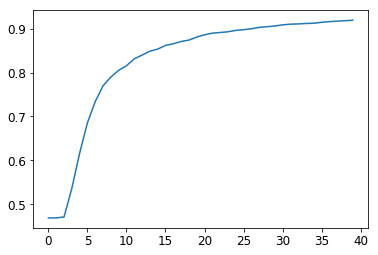

In [39]:
# the training progress is recorded in *recorder*

# plot accuracy over epochs
plt.plot(L(learn.recorder.values).itemgot(2));

# and observe the final accuracy
learn.recorder.values[-1][2]

# Going Deeper
ADD MOAR LAYERS!

(even better)

STEAL SOME LAYERS (Transfer Learning)

In [46]:
dls = ImageDataLoaders.from_folder(path)
learn = cnn_learner(dls, resnet18, pretrained=False,
                    loss_func=F.cross_entropy, metrics=accuracy)
learn.fit_one_cycle(1, 0.1)

TypeError: 'NoneType' object is not iterable